# Introduction

The goal of this exercise is to first mine/crawl/fetch data from a source and then conduct analysis and modelling on the dataset. For the data, we are going to use Reddit, which is one of the world's largest communities where people anonymously share ideas and discuss over many topics (each divided into mini-clubs called subreddits).

It is often said there is a subreddit for everything! For our problem statement, we are going to focus on the homepage. The global reddit homepage is the place that is shown to all users when they visit the site. Posts on reddit have a ranking feature based on upvotes and downvotes. Ultimately, the best of the best make it to the frontpage.

That's what we are trying to do with this problem statement: can we predict the upvote score or an upvote class for reddit posts on the frontpage. The idea is to crawl data, then clean it and preprocess it, derive features from it and then use all that to model it into some sort of regression.

In [442]:
# Loading Libraries

import pandas as pd
import numpy as np
import requests
from datetime import datetime, timezone
import json
import time
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

## Crawler

Below, we have written a crawler to fetch data from Reddit. While we experimented with the `reddit API` and the `pushshift API`, we finally wrote a manual crawler using `BeautifulSoup`. The crawler fetches data from the `old.reddit.com` reddit homepage which is still available for users. The reasoning was because the classes are much clearer and are not the server-side rendered classes of the new reddit homepage. In any case, the crawler successfully fetches data for the top posts on the homepage for the day.

The crawler performs the following tasks:

- Makes the Soup (webpage HTML)
- Gets the Next Page URL
- Extracts Data from one page of 25 entries
  - Title
  - Rank
  - Dislikes
  - Likes
  - Votes
  - Timestamp
  - Offset
  - Author
  - Comments
  - Thumbnails
  - Video Duration
  - Has Media?
  - Subreddit
  - Awards Count
  - More Awards
- Then, the Crawler goes to the Next Page
- This repeats till One of Three Conditions is Met:
  - The `pages` parameter is reached
  - The total posts end in the Time Filter
  - 1000 posts are collected
- The `dataset` is then returned

In [21]:
def make_soup(url, ua):
    
    '''
    This function creates and returns the BeautifulSoup object made from the UserAgent and the URL
    
    url - the URL to hit
    ua - the UserAgent object
    
    returns - BeautifulSoup object
    
    '''
    
    r = requests.get(url, headers={'User-Agent': ua.chrome})
    return BeautifulSoup(r.text, 'lxml')

def get_next_page(soup):
    
    '''
    This function finds the next page URL
    
    soup - the BeautifulSoup object
    
    returns - link (string)
    
    '''
    
    link = soup.find("span", class_ = "next-button")
    link = link.find("a").attrs['href']
    
    return link

def crawl_page(url, user_agent):
    
    '''
    This function makes the dataset for one page and also finds the next page URL
    
    url - the URL to hit
    user_agent - the UserAgent object
    
    returns - dataset (pandas DataFrame), next_page (string)
    
    '''
    
    soup = make_soup(url, user_agent)
    next_page = get_next_page(soup)
    
    titles = soup.findAll('p', {'class': 'title'})
    titles = [t.get_text() for t in titles]

    rank = soup.findAll('span', {'class': 'rank'})
    rank = [r.get_text() for r in rank]

    dislikes = soup.findAll('div', {'class': 'score dislikes'})
    dislikes = [d.get('title') for d in dislikes]

    likes = soup.findAll('div', {'class': 'score likes'})
    likes = [l.get('title') for l in likes]

    votes = soup.findAll('div', {'class': 'score unvoted'})
    votes = [v.get('title') for v in votes]

    timestamps = soup.findAll('time')
    offset = [t.get_text() for t in timestamps]
    timestamps = [t.get('datetime') for t in timestamps]

    authors = soup.findAll('a', {'class': 'author'})
    authors = [a.get_text() for a in authors]

    comments = soup.findAll('a', {'class': 'comments'})
    comments = [c.get_text().split(" ")[0] for c in comments]

    thumbnails = soup.findAll('a', {'class': 'thumbnail'})
    video_duration = [t.get_text() for t in thumbnails]
    has_media = [True if len(t.findAll('img')) > 0 else False for t in thumbnails]

    subreddit = soup.findAll('a', {'class': 'subreddit'})
    subreddit = [s.get_text().split("/")[1] for s in subreddit]

    awards = soup.findAll('span', {'class': 'awardings-bar'})
    awards = [a.findAll('a', {'class': 'awarding-link'}) for a in awards]
    award_counts = [[int(c.get('data-count')) for c in a] for a in awards]
    award_more = soup.findAll('a', {'class': 'awarding-show-more-link'})
    award_more = [a.get_text().split(" ")[1] for a in award_more]
    award_counts = [sum(a) for a in award_counts]
    
    data_list = [titles, rank, dislikes, likes, votes, offset, timestamps, authors, comments, has_media, video_duration, subreddit,
                award_counts, award_more]
    
    dataset = pd.concat([pd.Series(x) for x in data_list], axis=1)
    dataset.columns = ['titles', 'rank', 'dislikes', 'likes', 'votes', 'offset', 'timestamps', 'authors', 'comments',
                       'has_media', 'video_duration', 'subreddit', 'award_counts', 'award_more']
    
    return dataset, next_page

def crawl_data(url, pages=40):
    
    '''
    This function makes the large dataframe page-by-page
    
    url - the URL to hit
    pages - the maximum pages to hit (default=40)
    
    returns - dataset (pandas DataFrame)
    
    '''
    
    ua = UserAgent()
    
    counter = 1
    print(f'Hitting URL: {url}')
    dataset, next_page = crawl_page(url, ua)
    dataset = dataset[dataset['rank'] != ""] # remove Promoted
    print(f'Total Rows: {dataset.shape[0]}')
    
    try:
        
        while(counter <= pages):
        
            time.sleep(5)

            print(f'Hitting URL: {next_page}')
            new_data, next_page = crawl_page(next_page, ua)
            dataset = dataset.append(new_data)
            dataset = dataset[dataset['rank'] != ""] # remove Promoted
            print(f'Total Rows: {dataset.shape[0]}')

            counter += 1

            if (dataset.shape[0] == 1000):
                break
            
    except:
        
        print('End of Time Filter Reached.')
        
    return dataset

In [22]:
# Uncomment the following lines to run the crawler again

# url = 'https://old.reddit.com/r/all/top?sort=top&t=day'
# dataset = crawl_data(url)
# dataset.to_csv('reddit_data.csv', index=False)

Hitting URL: https://old.reddit.com/r/all/top?sort=top&t=day
Total Rows: 25
Hitting URL: https://old.reddit.com/r/all/top/?sort=top&t=day&count=25&after=t3_v7mxyh
Total Rows: 50
Hitting URL: https://old.reddit.com/r/all/top/?sort=top&t=day&count=50&after=t3_v7njis
Total Rows: 75
Hitting URL: https://old.reddit.com/r/all/top/?sort=top&t=day&count=75&after=t3_v7f4sz
Total Rows: 100
Hitting URL: https://old.reddit.com/r/all/top/?sort=top&t=day&count=100&after=t3_v7eufr
Total Rows: 125
Hitting URL: https://old.reddit.com/r/all/top/?sort=top&t=day&count=125&after=t3_v7uon8
Total Rows: 150
Hitting URL: https://old.reddit.com/r/all/top/?sort=top&t=day&count=150&after=t3_v7pcpm
Total Rows: 175
Hitting URL: https://old.reddit.com/r/all/top/?sort=top&t=day&count=175&after=t3_v7lyst
Total Rows: 200
Hitting URL: https://old.reddit.com/r/all/top/?sort=top&t=day&count=200&after=t3_v7ls1y
Total Rows: 225
Hitting URL: https://old.reddit.com/r/all/top/?sort=top&t=day&count=250&after=t3_v7qpvd
Total Row

In [23]:
# Comment the line below if above lines are uncommented

dataset = pd.read_csv('reddit_data.csv')

In [24]:
dataset.head()

,titles,rank,dislikes,likes,votes,offset,timestamps,authors,comments,has_media,video_duration,subreddit,award_counts,award_more
0,promise kept Good Vibes (v.redd.it),1,153468,153470,153469,13 hours ago,2022-06-08T09:39:35+00:00,55o,2011.0,True,0:59,MadeMeSmile,317.0,307.0
1,meirl (i.redd.it),2,122486,122488,122487,22 hours ago,2022-06-08T00:20:29+00:00,SnooCupcakes8607,3799.0,True,NaN,MadeMeSmile,120.0,70.0
2,just landed my dream job... to teach people ab...,3,105697,105699,105698,9 hours ago,2022-06-08T13:17:18+00:00,jillison_flook,388.0,True,NaN,memes,38.0,27.0
3,I miss Rick Moranis (i.redd.it),4,107427,107429,107428,11 hours ago,2022-06-08T11:52:23+00:00,davetowers646,1892.0,True,NaN,aww,84.0,2.0
4,Barely 7 am and I wake up to this HANGRY guy s...,5,87411,87413,87412,10 hours ago,2022-06-08T12:15:31+00:00,Greenveins,516.0,True,NaN,funny,28.0,10.0


In [25]:
dataset.shape

(775, 14)

In [34]:
dataset.columns.tolist()

['titles',
 'rank',
 'dislikes',
 'likes',
 'votes',
 'offset',
 'timestamps',
 'authors',
 'comments',
 'has_media',
 'video_duration',
 'subreddit',
 'award_counts',
 'award_more']

## Data Cleaning & Feature Generation

For the next part, we will take the dataframe and clean it a little. We will also derive some features from the existing ones to make sure we have data that is of value. Beyond Feature Generation, we will also handle missing values as well as some other stuff.

In [314]:
new_dataset = dataset.copy()

### Has Picture

If `has_media` is `True` and if `video_duration` is `NaN`, that means the media is a picture.

In [315]:
new_dataset.loc[(new_dataset.has_media == True) & (pd.isna(new_dataset.video_duration)), 'has_picture'] = True

In [316]:
new_dataset.has_picture.fillna(False, inplace=True)

### Total Awards

The way the data is structured on the website, it is difficult to add total awards and awards in the more section. We will do that addition now.

In [393]:
new_dataset['award_counts'].fillna(0, inplace=True)
new_dataset['award_more'].fillna(0, inplace=True)
new_dataset['total_awards'] = new_dataset['award_counts'] + new_dataset['award_more']
new_dataset.drop(['award_counts', 'award_more'], axis=1, inplace=True)

### Offset

Offset is the timestamp measure of how long ago something was posted. This variable is more informative than timestamp. We will remove timestamp and clean this variable instead.

In [318]:
new_dataset.drop('timestamps', axis=1, inplace=True)

In [319]:
new_dataset['offset'].fillna("0 hours ago", inplace=True)
new_dataset['offset'] = new_dataset['offset'].str.replace("hours ago", "")

In [320]:
new_dataset['offset'] = new_dataset['offset'].replace({'\*': 0}, regex=True)
new_dataset['offset'] = new_dataset['offset'].astype('int')

### Like-Dislike Ratio

Since we have both likes and dislikes, we will convert them into a ratio to make the variables more informative.

In [321]:
new_dataset['like_dislike'] = new_dataset['likes'] / new_dataset['dislikes']

In [322]:
new_dataset.drop(['likes', 'dislikes'], axis=1, inplace=True)

### Video Duration (in secs)

The video duration column has timestamps mm:ss for the video durations. We will convert this to seconds only.

In [323]:
new_dataset['video_duration'].fillna("0:00", inplace=True)
video_duration = new_dataset["video_duration"].str.split(":", expand=True)
video_duration['video_duration_secs'] = video_duration[0].astype(int) * 60 + video_duration[1].astype(int)

In [324]:
new_dataset['video_duration_secs'] = video_duration['video_duration_secs']

In [325]:
new_dataset.drop('video_duration', axis=1, inplace=True)

### Title Character Counts

The title character has a title and a link. We will split it into the two and then calculate the length of characters for the first bit.

In [326]:
new_dataset['titles'] = new_dataset.titles.apply(lambda x: x.split("(")[0])
new_dataset['title_characters'] = new_dataset.titles.apply(len)

### Title Word Count

Like the variable above, we are going to calculate the word counts (based on spaces).

In [327]:
new_dataset['title_word_count'] = new_dataset.titles.str.split().str.len()

In [328]:
new_dataset.drop('titles', axis=1, inplace=True)

### Author Name Count

The author name does not give us much info but a shorter author name is easier to pronounce/read. Maybe that gives some information.

In [329]:
new_dataset['author_name_count'] = new_dataset.authors.apply(len)

In [330]:
new_dataset.drop('authors', axis=1, inplace=True)

### Dropping Rank

We don't need the rank since it is an explicit measure of the votes itself. To use it in the model will be overfitting it.

In [331]:
new_dataset.drop('rank', axis=1, inplace=True)

### One-Hot Encoding Subreddits

We are going to create dummy variables from the subreddit column.

In [332]:
new_dataset = pd.concat([new_dataset,
                        pd.get_dummies(new_dataset['subreddit'], prefix='sub_')],
                        axis=1)

In [333]:
new_dataset.drop('subreddit', inplace=True, axis=1)

### Creating Groups for Votes

While a strict regression is a great idea, it is difficult to measure accuracy and results. It is easier to predict whether the prediction falls within a range. Hence, we will encode the `votes` to groups.

In [334]:
min(new_dataset.votes)

3810

In [335]:
max(new_dataset.votes)

153469

In [336]:
bins = pd.interval_range(start=min(new_dataset.votes)-1, freq=10000, end=max(new_dataset.votes)+10000, closed='left')

In [337]:
bins

IntervalIndex([[3809, 13809), [13809, 23809), [23809, 33809), [33809, 43809), [43809, 53809) ... [103809, 113809), [113809, 123809), [123809, 133809), [133809, 143809), [143809, 153809)],
              closed='left',
              dtype='interval[int64]')

In [338]:
new_dataset['votes_bin'] = pd.cut(new_dataset.votes, bins = bins)

In [339]:
new_dataset.drop('votes', inplace=True, axis=1)

## Exploratory Data Analysis

For each of the features above, we will plot and do some kind of exploratory analysis.

### Has Picture

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<AxesSubplot:xlabel='has_picture', ylabel='Count'>

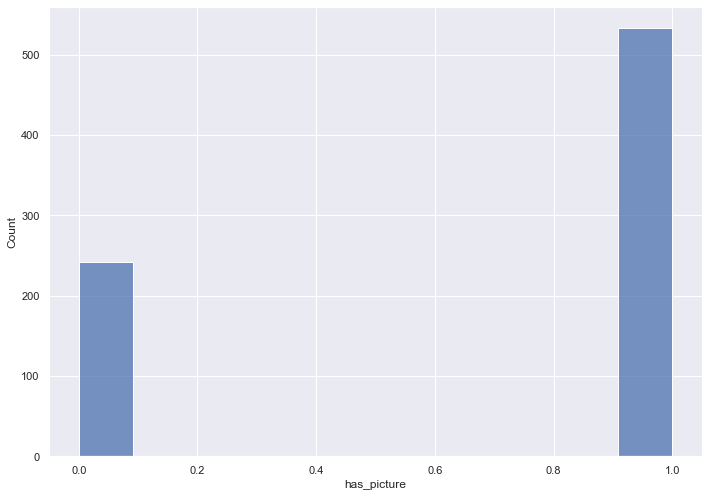

In [377]:
sns.histplot(new_dataset.has_picture)

We can see that roughly 250 posts don't have a picture while about 500 of them do. Let's compare and contrast this with `has_media`.

### Has Media

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<AxesSubplot:xlabel='has_media', ylabel='Count'>

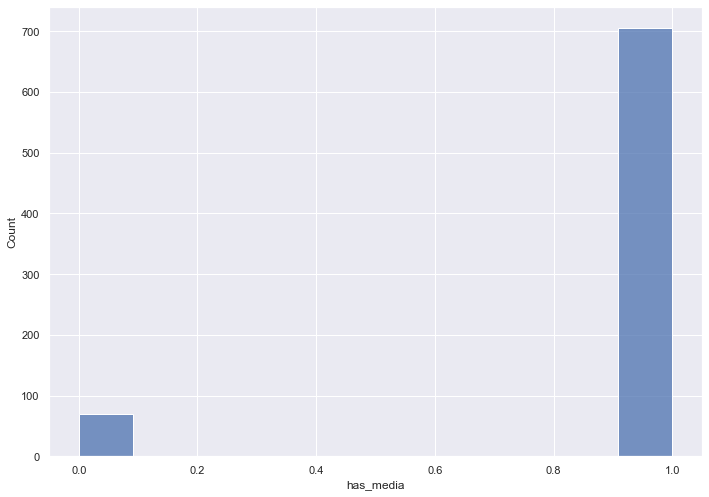

In [378]:
sns.histplot(new_dataset.has_media)

The difference between `has_picture` and `has_media` is the posts with videos instead. Let's look at how the `video_duration_secs` is distributed.

### Video Duration (in seconds)

<AxesSubplot:xlabel='video_duration_secs', ylabel='Count'>

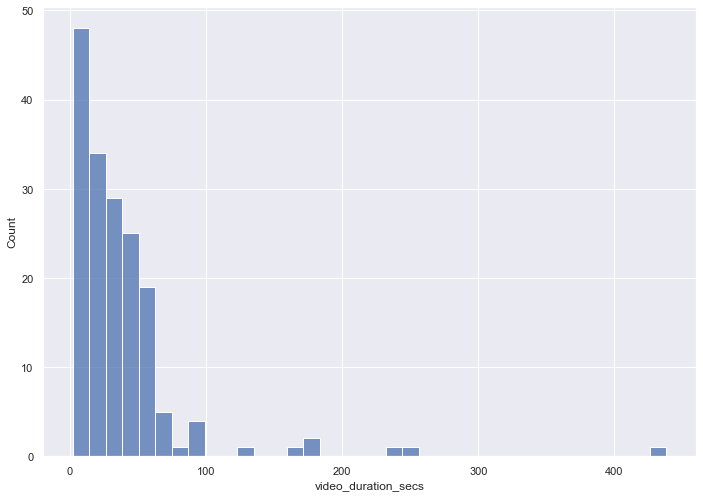

In [379]:
sns.histplot(new_dataset[new_dataset.video_duration_secs > 0].video_duration_secs)

<AxesSubplot:xlabel='video_duration_secs'>

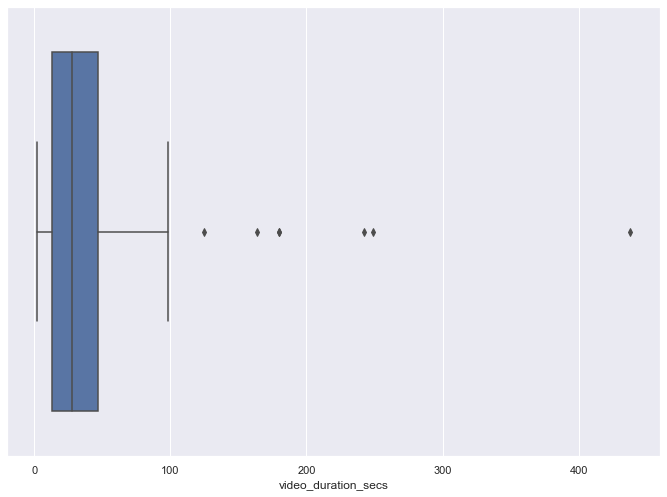

In [380]:
sns.boxplot(new_dataset[new_dataset.video_duration_secs > 0].video_duration_secs)

Most videos are shorter than `60` seconds or a minute. A few outliers exist but beyon that the data is heavily left-skewed. In fact, the median is closer to 0 than it is to 60.

In [381]:
pd.DataFrame(new_dataset[new_dataset.video_duration_secs > 0].video_duration_secs.describe())

,video_duration_secs
count,172.000000
mean,38.343023
std,47.970188
min,2.000000
25%,13.000000
50%,27.500000
75%,47.000000
max,438.000000


Let's view the `total_awards` variable.

### Total Awards

<AxesSubplot:xlabel='total_awards', ylabel='Count'>

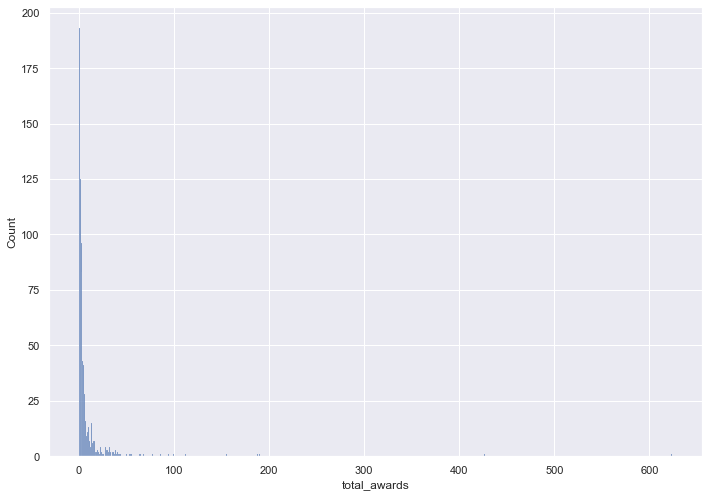

In [382]:
sns.histplot(new_dataset.total_awards)

<AxesSubplot:xlabel='total_awards'>

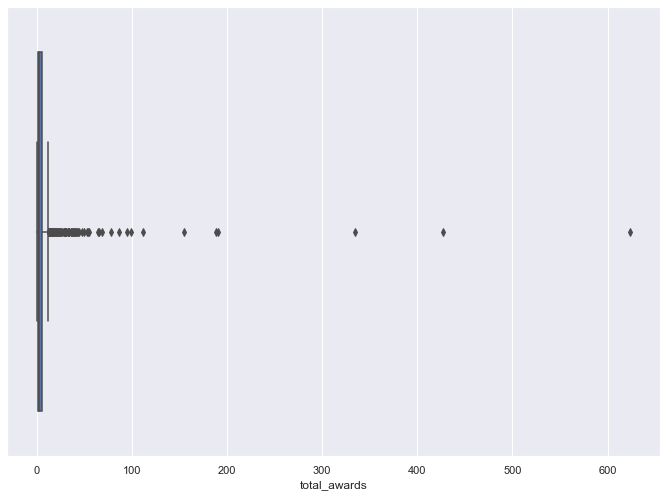

In [383]:
sns.boxplot(new_dataset.total_awards)

In [384]:
pd.DataFrame(new_dataset.total_awards.describe())

,total_awards
count,775.000000
mean,8.406452
std,33.316371
min,0.000000
25%,1.000000
50%,2.000000
75%,5.500000
max,624.000000


Most posts don't have awards. In fact, we can see that till the 75th quantile, the awards is 5.5 or ~6 which leaps to 624 to the 100th quantile. In other words, this suggests that awards are a unique property, which may influence a lot over the votes.

### Offset

<AxesSubplot:xlabel='offset', ylabel='Count'>

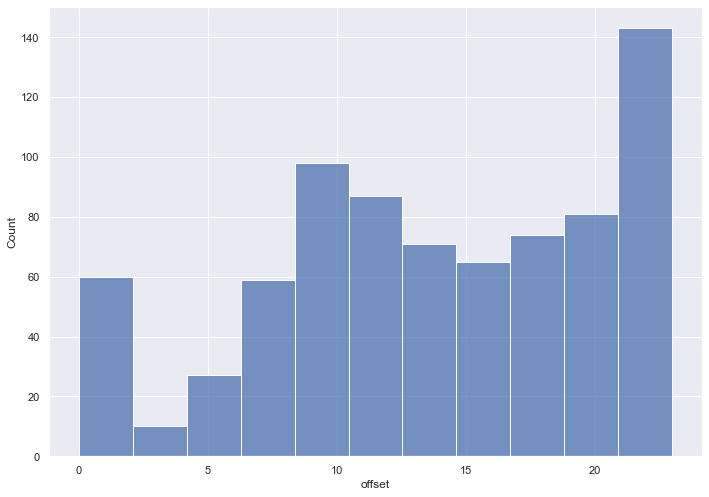

In [385]:
sns.histplot(new_dataset.offset)

Most posts are older than 20 hours on the homepage. This is an interesting distribution. It suggests there is a timeline 0-5 hours where only few posts make it to the homepage.

### Title Character Counts

<AxesSubplot:xlabel='title_characters', ylabel='Count'>

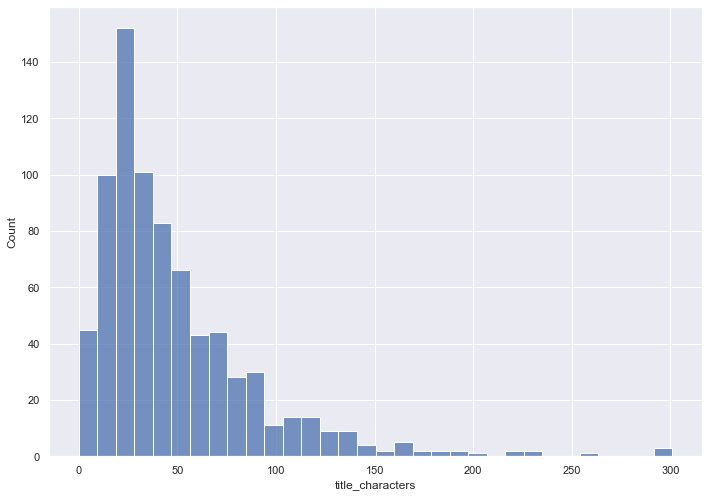

In [386]:
sns.histplot(new_dataset.title_characters)

Most titles are within 0-50 characters. This seems to be the sweet spot in the distribution.

### Title Words

<AxesSubplot:xlabel='title_word_count', ylabel='Count'>

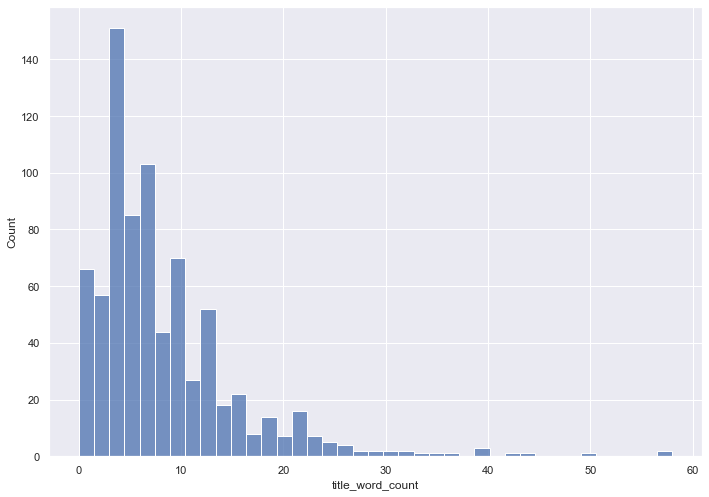

In [387]:
sns.histplot(new_dataset.title_word_count)

Most titles have roughly 5-6 words. Almost all posts have titles with 0-10 words.

### Author Name Count

<AxesSubplot:xlabel='author_name_count', ylabel='Count'>

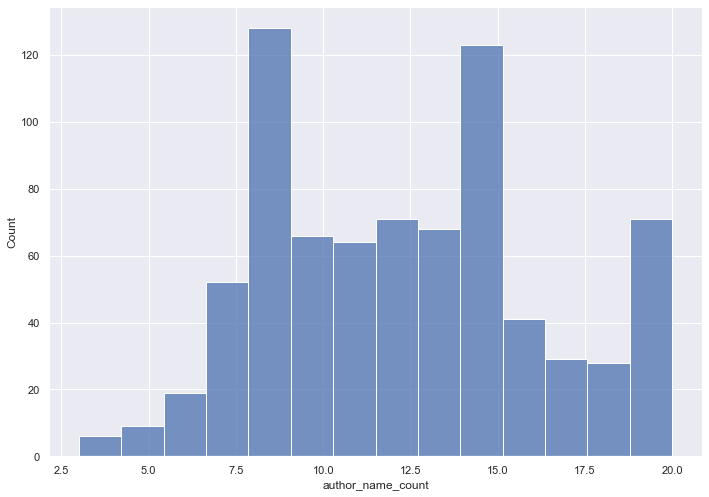

In [388]:
sns.histplot(new_dataset.author_name_count)

Most author names have 8 characters in them. The maximum seems to be 20.

### Like-Dislike Ratio

<AxesSubplot:xlabel='like_dislike', ylabel='Count'>

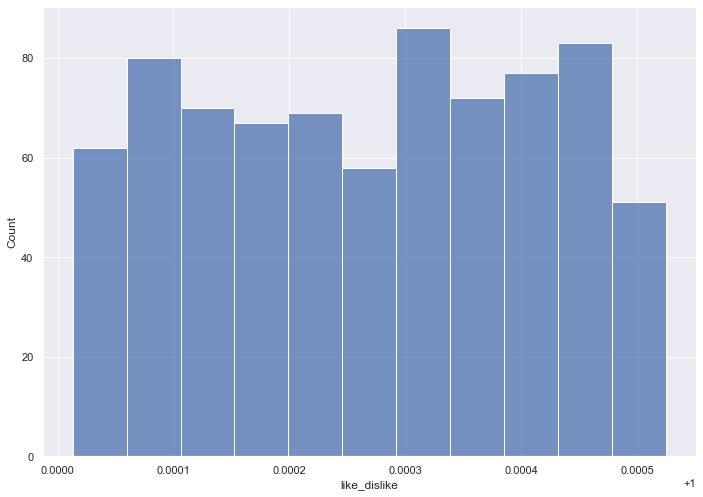

In [389]:
sns.histplot(new_dataset.like_dislike)

The like dislike ratio is evenly distributed for all values. From a modelling perspective, this does not seem to have a lot of information in it.

## Correlation

We will check for correlation in the data barring the subreddit one-hot encoding values.

In [396]:
corr_set = new_dataset[['offset','comments','has_media', 'has_picture','total_awards','like_dislike','video_duration_secs','title_characters','title_word_count','author_name_count']]

In [397]:
corr_set.corr()

,offset,comments,has_media,has_picture,total_awards,like_dislike,video_duration_secs,title_characters,title_word_count,author_name_count
offset,1.000000,-0.066948,0.064079,-0.020915,0.049576,-0.038523,-0.003203,-0.085722,-0.077588,0.025418
comments,-0.066948,1.000000,-0.005923,-0.044976,0.162925,-0.285970,0.032368,-0.007059,-0.020964,0.058582
has_media,0.064079,-0.005923,1.000000,0.467639,0.016285,-0.086424,0.097163,-0.286383,-0.276914,-0.033962
has_picture,-0.020915,-0.044976,0.467639,1.000000,-0.026814,-0.011165,-0.457618,-0.101832,-0.101093,0.007007
total_awards,0.049576,0.162925,0.016285,-0.026814,1.000000,-0.221680,0.031861,-0.033702,-0.035036,-0.030845
like_dislike,-0.038523,-0.285970,-0.086424,-0.011165,-0.221680,1.000000,-0.096547,0.060570,0.058256,-0.006475
video_duration_secs,-0.003203,0.032368,0.097163,-0.457618,0.031861,-0.096547,1.000000,0.022899,0.023103,0.004087
title_characters,-0.085722,-0.007059,-0.286383,-0.101832,-0.033702,0.060570,0.022899,1.000000,0.978673,-0.033689
title_word_count,-0.077588,-0.020964,-0.276914,-0.101093,-0.035036,0.058256,0.023103,0.978673,1.000000,-0.028335
author_name_count,0.025418,0.058582,-0.033962,0.007007,-0.030845,-0.006475,0.004087,-0.033689,-0.028335,1.000000


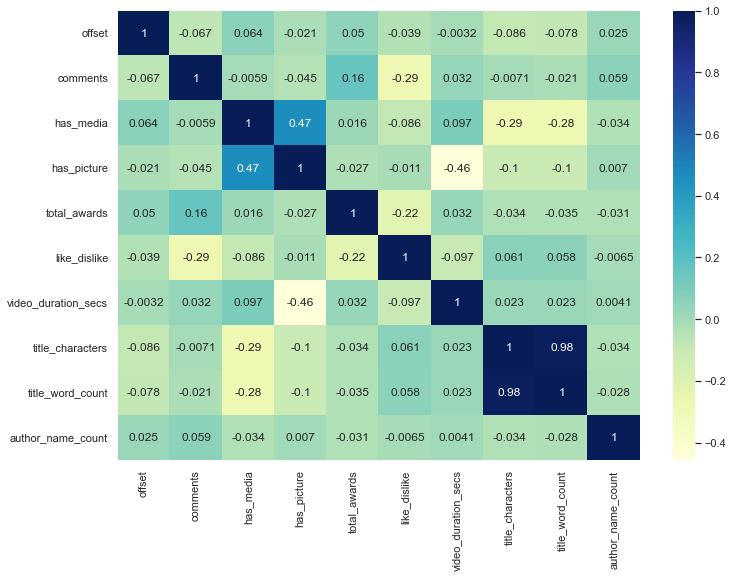

In [398]:
dataplot = sns.heatmap(corr_set.corr(), cmap="YlGnBu", annot=True)

There are some mild correlations but the major correlation is between `title_word_count` and `title_characters`. So, we will drop one of them.

In [400]:
new_dataset.drop('title_word_count', axis=1, inplace=True)

In [429]:
new_dataset.comments.fillna(0, inplace=True)

## Model Building

Now, we will try to build a multilevel classification model and try to find if we can correctlhy predict the upvote range of the data. This is the variable that is visualised below.

In [414]:
summary = pd.DataFrame(new_dataset.votes_bin.value_counts()).reset_index()
summary.columns = ['bins', 'count']

[Text(0, 0, '[3809, 13809)'),
 Text(1, 0, '[13809, 23809)'),
 Text(2, 0, '[23809, 33809)'),
 Text(3, 0, '[33809, 43809)'),
 Text(4, 0, '[43809, 53809)'),
 Text(5, 0, '[53809, 63809)'),
 Text(6, 0, '[63809, 73809)'),
 Text(7, 0, '[73809, 83809)'),
 Text(8, 0, '[83809, 93809)'),
 Text(9, 0, '[93809, 103809)'),
 Text(10, 0, '[103809, 113809)'),
 Text(11, 0, '[113809, 123809)'),
 Text(12, 0, '[123809, 133809)'),
 Text(13, 0, '[133809, 143809)'),
 Text(14, 0, '[143809, 153809)')]

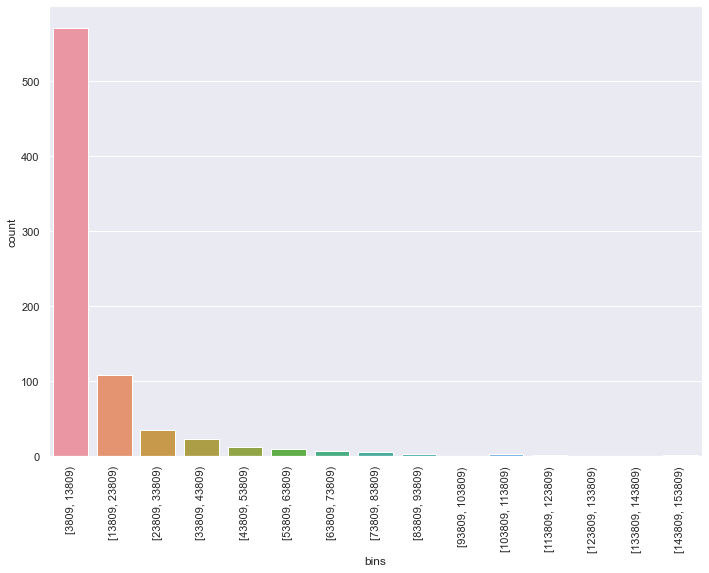

In [420]:
ax = sns.barplot(x='bins', y='count', data=summary)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

### Splitting the Data

Below, we will split the data into a 75-25 ratio for Train and Test sets. 

In [443]:
label_encoder = LabelEncoder()
new_dataset['votes_bin']= label_encoder.fit_transform(new_dataset['votes_bin']) 

X_train, X_test, y_train, y_test = train_test_split(new_dataset.drop('votes_bin', axis=1), new_dataset['votes_bin'],
                                                    test_size=0.25, random_state=42)

### Logistic Regression

In [444]:
lr = LogisticRegression(random_state=42).fit(X_train, y_train)

In [463]:
lr_train = round(lr.score(X_train, y_train)*100, 2)
lr_test = round(lr.score(X_test, y_test)*100, 2)

print(f'The Train Accuracy for the Logistic Regression is {lr_train}%')
print(f'The Test Accuracy for the Logistic Regression is {lr_test}%')

The Train Accuracy for the Logistic Regression is 73.15%
The Test Accuracy for the Logistic Regression is 73.71%


### Decision Tree

In [456]:
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [464]:
dt_train = round(dt.score(X_train, y_train)*100, 2)
dt_test = round(dt.score(X_test, y_test)*100, 2)

print(f'The Train Accuracy for the Decision Tree is {dt_train}%')
print(f'The Test Accuracy for the Decision Tree is {dt_test}%')

The Train Accuracy for the Decision Tree is 100.0%
The Test Accuracy for the Decision Tree is 98.97%


### SVC

In [460]:
svc = SVC(random_state = 42).fit(X_train, y_train)

In [465]:
svc_train = round(svc.score(X_train, y_train)*100, 2)
svc_test = round(svc.score(X_test, y_test)*100, 2)

print(f'The Train Accuracy for the SVC is {svc_train}%')
print(f'The Test Accuracy for the SVC is {svc_test}%')

The Train Accuracy for the SVC is 74.01%
The Test Accuracy for the SVC is 73.71%


### Comparisons

We will now compare the accuracies across the board.

In [468]:
train_list = pd.Series([lr_train, dt_train, svc_train])
test_list = pd.Series([lr_test, dt_test, svc_test])
models = pd.Series(['Logistic Regression', 'Decision Tree', 'SVC'])

In [472]:
model_summary = pd.concat([models, train_list, test_list], axis=1)
model_summary.columns = ['model', 'train_accuracy', 'test_accuracy']
model_summary

,model,train_accuracy,test_accuracy
0,Logistic Regression,73.15,73.71
1,Decision Tree,100.00,98.97
2,SVC,74.01,73.71


<AxesSubplot:xlabel='model', ylabel='train_accuracy'>

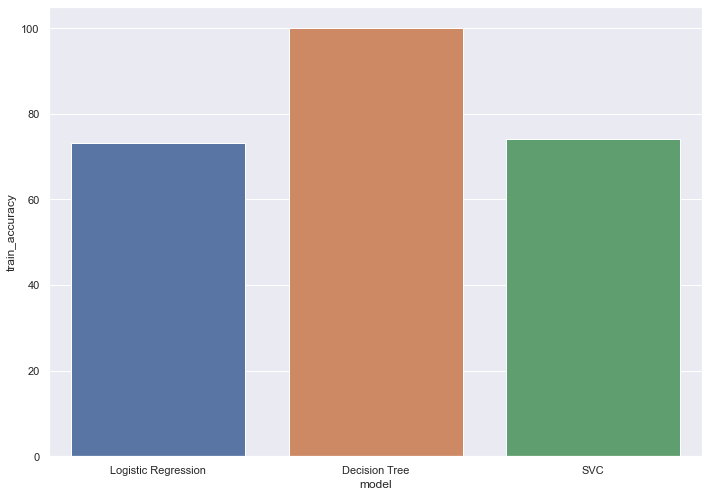

In [474]:
sns.barplot(x='model', y='train_accuracy', data=model_summary)

<AxesSubplot:xlabel='model', ylabel='test_accuracy'>

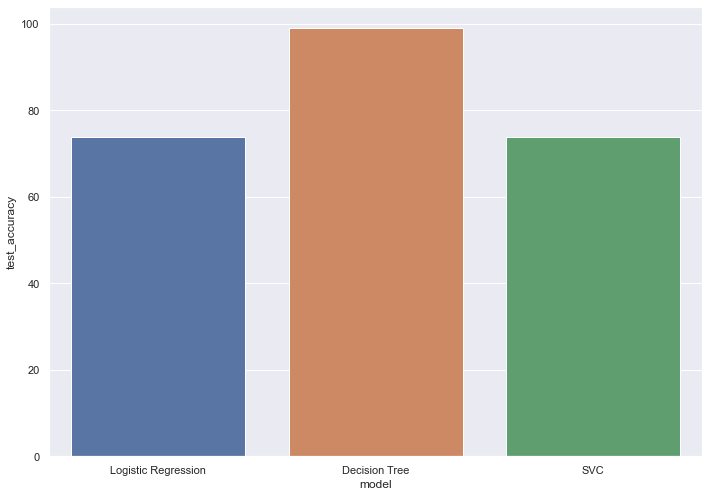

In [475]:
sns.barplot(x='model', y='test_accuracy', data=model_summary)

# Conclusion

From the above, we can conclude that a Decision Tree classifier can successfully predict the bin for the number of votes that a reddit post gets based on a list of factors (and some derived variables). This also factors in which subreddits the posts are posted in. All in all, it is interesting to see that with the data available right in front of the user's eyes, a user can make sense of what makes a post appear on the homepage, and what gives it a higher number of votes.

As part of this exercise, we have built a crawler, then fetched some data, conducted EDA on it, transformed it into informative variables and then conducted modelling on the same. It has been a very interesting and intriguing exercise overall.